## Classificação de Sequências em Texto com GRUs

In [1]:
import tensorflow as tf
tf.__version__

'2.5.0'

In [2]:
import keras as k
k.__version__

'2.5.0'

In [21]:
# Imports
import os
import io
import json
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, GRU
from keras.layers import SpatialDropout1D
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.layers import Dropout
from keras.layers.convolutional import Convolution1D
from keras.layers.convolutional import MaxPooling1D
from keras_preprocessing.text import tokenizer_from_json
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    
from time import time
import re
import unidecode
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from plotly.offline import iplot
import cufflinks
cufflinks.go_offline()
cufflinks.set_config_file(world_readable=True, theme='pearl')
from os.path import isfile
from keras.callbacks import EarlyStopping
from keras.models import load_model

In [4]:
# Random seed
np.random.seed(42)

In [5]:
# carrega os dados
df = pd.read_csv('./Data/Ocorrencias_290.csv', encoding='utf8')
df = df[['des_historico','codigo']]
df

,des_historico,codigo
0,durante patrulhamento acionados vitima jeane r...,B01129
1,deslocamos ate rua jose lindolfo leite 412 cen...,B01129
2,acionados comparecemos local supra citado onde...,B01129
3,patrulhamento local guarnicao deparou vitima q...,B01129
4,segundo vitima apos desentendimento familiar a...,B01129
...,...,...
1739220,procurados senhor clenon relatou data 02 11 20...,T00009
1739221,empenhados copom comparecemos local avenida br...,T00009
1739222,acionados copom deslocamos cruzamento avenida ...,T00009
1739223,patrulhamento deparamos vp 26995 comandada sen...,T00009


In [6]:
df.codigo.value_counts()

T00008    289955
C01155    289917
T00009    289909
C01157    289898
B01129    289884
C01171    289662
Name: codigo, dtype: int64

In [7]:
df.isnull().sum()

des_historico    0
codigo           0
dtype: int64

In [8]:
df.dropna(subset=['des_historico'], inplace=True)

In [9]:
df.codigo.value_counts()

T00008    289955
C01155    289917
T00009    289909
C01157    289898
B01129    289884
C01171    289662
Name: codigo, dtype: int64

In [10]:
# Labels na sequência em que aparecem os códigos
possible_labels = df.codigo.unique()
possible_labels

array(['B01129', 'C01155', 'C01157', 'C01171', 'T00008', 'T00009'],
      dtype=object)

In [11]:
labels_DL = ['B01129', 'C01155',  'C01157', 'C01171', 'T00008', 'T00009']
#'B01129', 'C01155', 'C01157', 'C01171', 'T00008', 'T00009'
labels_DL

['B01129', 'C01155', 'C01157', 'C01171', 'T00008', 'T00009']

In [12]:
labels_Categoria =  ['LESAO CORPORAL', 'FURTO',  'ROUBO', 'ESTELIONATO', 'ACIDENTE DE TRANSITO SEM VITIMA', 
                    'ACIDENTE DE TRANSITO COM VITIMA']
#'B01129', 'C01155', 'C01157', 'C01171', 'T00008', 'T00009'
labels_Categoria

['LESAO CORPORAL',
 'FURTO',
 'ROUBO',
 'ESTELIONATO',
 'ACIDENTE DE TRANSITO SEM VITIMA',
 'ACIDENTE DE TRANSITO COM VITIMA']

In [13]:
labels_descricao = ['B01129 - LESAO CORPORAL', 'C01155 - FURTO',  'C01157 - ROUBO', 'C01171 - ESTELIONATO', 'T00008 - ACIDENTE DE TRANSITO SEM VITIMA', 
                    'T00009 - ACIDENTE DE TRANSITO COM VITIMA']
#'B01129', 'C01155', 'C01157', 'C01171', 'T00008', 'T00009'
labels_descricao

['B01129 - LESAO CORPORAL',
 'C01155 - FURTO',
 'C01157 - ROUBO',
 'C01171 - ESTELIONATO',
 'T00008 - ACIDENTE DE TRANSITO SEM VITIMA',
 'T00009 - ACIDENTE DE TRANSITO COM VITIMA']

In [14]:
df['codigo'].value_counts().sort_values(ascending=False).iplot(kind='bar', yTitle='Número de textos em cada ocorrência', 
                                                                title='Número de ocorrências de um total de 1.739.225')

In [ ]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100

In [15]:
# Cria ou carrega o tokenizer, caso exista
TOKEN_PATH = './Modelo/tokenizer_290.json'

if isfile(TOKEN_PATH):
    # carrega tokenizer
    with open('./Modelo/tokenizer_290.json') as f:
        data = json.load(f)
        tokenizer = tokenizer_from_json(data) 
        tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True) 
else:
    # cria tokenizer
    tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
    tokenizer.fit_on_texts(df['des_historico'].values)
    word_index = tokenizer.word_index
    print('Found %s unique tokens.' % len(word_index))
    
    tokenizer_json = tokenizer.to_json()
    with io.open ('./Modelo/tokenizer_290.json', 'w', encoding='utf-8') as f:
        f.write(json.dumps(tokenizer_json, ensure_ascii=False))    

Found 2205146 unique tokens.


In [16]:
X = tokenizer.texts_to_sequences(df['des_historico'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (1739225, 250)


In [17]:
Y = pd.get_dummies(df['codigo']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (1739225, 6)


In [18]:
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size = 0.30, random_state = 42)
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(1217457, 250) (1217457, 6)
(521768, 250) (521768, 6)


In [19]:
!nvidia-smi

Fri Jun 25 08:33:08 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 466.77       Driver Version: 466.77       CUDA Version: 11.3     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
|  0%   30C    P8    N/A /  72W |    393MiB /  4096MiB |      5%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Deep Learning Algoritmo GRUs - Versão 1

In [22]:
# Treinamento_DL_290_GRU_01
start = time()
MODEL_PATH = './Modelo/Ocorrencia_290_GRU_01.h5'

# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000

if isfile(MODEL_PATH):
    model = load_model(MODEL_PATH)
    history = model
else:
    # Cria o Modelo
    embedding_vector_length = 100
    
    model = Sequential()
    model.add(Embedding(MAX_NB_WORDS, embedding_vector_length, input_length=X.shape[1]))
    # GRU - tensorflow-gpu=2.0.0, Python 3.8
    model.add(GRU(100))  
    model.add(Dense(6, activation = 'softmax'))
    model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    print(model.summary())
    
    # Treina o Modelo
    epochs = 10
    batch_size = 64
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,
                        callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.00001)]) 
    
    # Avaliação final do modelo
    scores = model.evaluate(X_test, y_test, verbose = 0)
    print("Acurácia: %.2f%%" % (scores[1]*100))     

    model.save(MODEL_PATH)
    
    # model.fit(X_train, y_train, epochs = 10, batch_size = 64)

    # calcula o tempo de execução
    print ('\nTempo gasto: %s segundos' % str(time() - start))

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 250, 100)          5000000   
_________________________________________________________________
gru (GRU)                    (None, 100)               60600     
_________________________________________________________________
dense (Dense)                (None, 6)                 606       
Total params: 5,061,206
Trainable params: 5,061,206
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
17121/17121 [==============================] - 1267s 72ms/step - loss: 0.1953 - accuracy: 0.9302 - val_loss: 0.0735 - val_accuracy: 0.9766
Epoch 2/10
17121/17121 [==============================] - 1222s 71ms/step - loss: 0.0600 - accuracy: 0.9808 - val_loss: 0.0702 - val_accuracy: 0.9775
Epoch 3/10
17121/17121 [==============================] - 1222s 71ms/

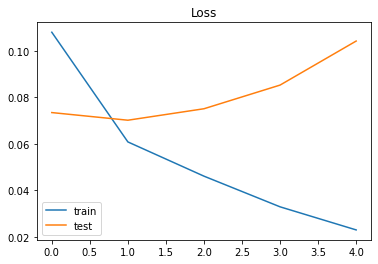

In [23]:
# modelo 290_GRU_01
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

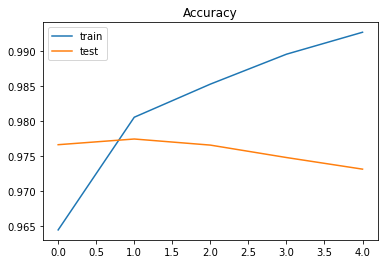

In [24]:
# Modelo 290_GRU_01
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

## GRUs e CNNs Para Classificação de Sequências - Versão 2

As redes neurais convolucionais são excelentes para aprender a estrutura espacial em dados de entrada. No IMDB os dados de reviews têm uma estrutura espacial unidimensional na sequência de palavras nas revisões e uma CNN poderá escolher características invariantes para o sentimento bom e ruim. Estas características espaciais aprendidas podem então ser aprendidas como sequências por uma camada LSTM. Podemos facilmente adicionar uma CNN unidimensional e as camadas de Max Pooling após a camada Embedding que, em seguida, alimente os recursos consolidados para o LSTM. Podemos usar um pequeno conjunto de 32 recursos com um pequeno filtro de comprimento igual a 3. A camada de pooling pode usar o comprimento padrão de 2 para reduzir a metade o tamanho do mapa de recursos.

In [25]:
# Treinamento_DL_290_GRU_CNN_02
start = time()
MODEL_PATH = './Modelo/Ocorrencia_290_GRU_CNN_02.h5'

if isfile(MODEL_PATH):
    model = load_model(MODEL_PATH)
    history = model
else:
    embedding_vector_length = 100
    model = Sequential()
    model.add(Embedding(MAX_NB_WORDS, embedding_vector_length, input_length=X.shape[1]))
    model.add(Convolution1D(filters = 32, kernel_size = 3, padding = 'same', activation = 'relu'))
    model.add(MaxPooling1D(pool_size = 2))
    model.add(GRU(100, dropout=0.2, recurrent_dropout=0, activation='tanh', recurrent_activation='sigmoid', return_sequences=True))  
    model.add(GRU(100, dropout=0.2, recurrent_dropout=0, activation='tanh', recurrent_activation='sigmoid')) 
    model.add(Dense(6, activation = 'sigmoid'))
    model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    print(model.summary())
    
    # Treina o Modelo
    epochs = 5
    batch_size = 64
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,
                        callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)]) 
    
    model.save(MODEL_PATH)
    
    # model.fit(X_train, y_train, epochs = 10, batch_size = 64)
    
    # Avaliação final do modelo
    scores = model.evaluate(X_test, y_test, verbose = 0)
    print("Acurácia: %.2f%%" % (scores[1]*100))    

    # calcula o tempo de execução
    print ('\nTempo gasto: %s segundos' % str(time() - start))  

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 250, 100)          5000000   
_________________________________________________________________
conv1d (Conv1D)              (None, 250, 32)           9632      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 125, 32)           0         
_________________________________________________________________
gru_1 (GRU)                  (None, 125, 100)          40200     
_________________________________________________________________
gru_2 (GRU)                  (None, 100)               60600     
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 606       
Total params: 5,111,038
Trainable params: 5,111,038
Non-trainable params: 0
____________________________________________

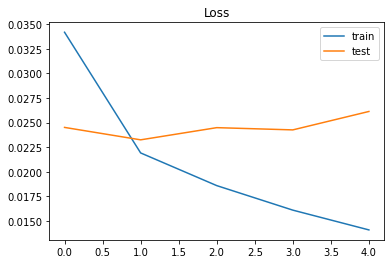

In [26]:
# modelo 290_GRU_CNN_02
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

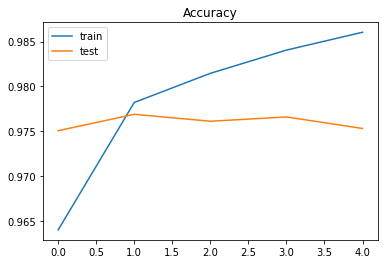

In [27]:
# Modelo 290_GRU_CNN_02
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

## Aplicando Regularização com Dropout em GRUs - Versão 3

In [28]:
# Treinamento_DL_290_GRU_03
start = time()
MODEL_PATH = './Modelo/Ocorrencia_290_GRU_03.h5'

if isfile(MODEL_PATH):
    model = load_model(MODEL_PATH)
    history = model
else:
    embedding_vector_length = 100
    model = Sequential()
    model.add(Embedding(MAX_NB_WORDS, embedding_vector_length, input_length=X.shape[1]))
    model.add(GRU(200, dropout=0.2, recurrent_dropout=0, activation='tanh', recurrent_activation='sigmoid', return_sequences=True))  
    model.add(GRU(200, dropout=0.2, recurrent_dropout=0, activation='tanh', recurrent_activation='sigmoid'))
    model.add(Dense(6, activation = 'softmax'))
    model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    print(model.summary())
    
    # Treina o Modelo
    epochs = 10
    batch_size = 64
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,
                        callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)]) 
    
    model.save(MODEL_PATH)
    
    # model.fit(X_train, y_train, epochs = 10, batch_size = 64)
    
    # Avaliação final do modelo
    scores = model.evaluate(X_test, y_test, verbose = 0)
    print("Acurácia: %.2f%%" % (scores[1]*100))    

    # calcula o tempo de execução
    print ('\nTempo gasto: %s segundos' % str(time() - start))  

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 250, 100)          5000000   
_________________________________________________________________
gru_3 (GRU)                  (None, 250, 200)          181200    
_________________________________________________________________
gru_4 (GRU)                  (None, 200)               241200    
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 1206      
Total params: 5,423,606
Trainable params: 5,423,606
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
17121/17121 [==============================] - 1862s 108ms/step - loss: 0.1794 - accuracy: 0.9375 - val_loss: 0.0739 - val_accuracy: 0.9758
Epoch 2/10
17121/17121 [==============================] - 1854s 108ms/step - loss: 0.0

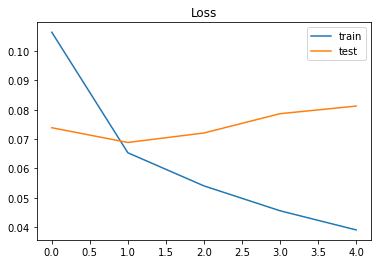

In [29]:
# modelo 290_GRU_03
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

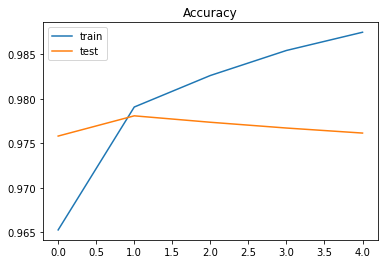

In [30]:
# Modelo 290_GRU_03
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

In [31]:
# Treinamento_DL_290_GRU_04
start = time()
MODEL_PATH = './Modelo/Ocorrencia_290_GRU_04.h5'

if isfile(MODEL_PATH):
    model = load_model(MODEL_PATH)
    history = model
else:
    embedding_vector_length = 100
    model = Sequential()
    model.add(Embedding(MAX_NB_WORDS, embedding_vector_length, input_length=X.shape[1])) 
    model.add(GRU(200, dropout=0.2, recurrent_dropout=0, activation='tanh', recurrent_activation='sigmoid', return_sequences=True))  
    model.add(GRU(200, dropout=0.2, recurrent_dropout=0, activation='tanh', recurrent_activation='sigmoid'))
    model.add(Dense(6, activation = 'sigmoid'))
    model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])    
    print(model.summary())
    
    # Treina o Modelo
    epochs = 10
    batch_size = 64
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,
                        callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)]) 
    
    model.save(MODEL_PATH)
    
    # model.fit(X_train, y_train, epochs = 10, batch_size = 64)
    
    # Avaliação final do modelo
    scores = model.evaluate(X_test, y_test, verbose = 0)
    print("Acurácia: %.2f%%" % (scores[1]*100))    

    # calcula o tempo de execução
    print ('\nTempo gasto: %s segundos' % str(time() - start))  

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 250, 100)          5000000   
_________________________________________________________________
gru_5 (GRU)                  (None, 250, 200)          181200    
_________________________________________________________________
gru_6 (GRU)                  (None, 200)               241200    
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 1206      
Total params: 5,423,606
Trainable params: 5,423,606
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
17121/17121 [==============================] - 1918s 112ms/step - loss: 0.0532 - accuracy: 0.9368 - val_loss: 0.0233 - val_accuracy: 0.9762
Epoch 2/10
17121/17121 [==============================] - 1959s 114ms/step - loss: 0.0

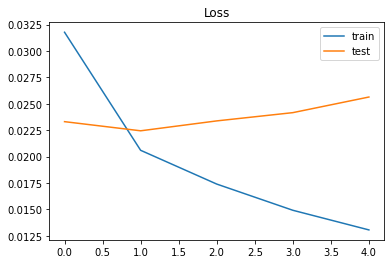

In [32]:
# modelo 290_GRU_04
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

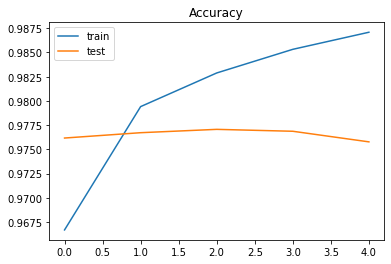

In [33]:
# Modelo 290_GRU_04
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

# Fim